# 08/03/2023 - Lab 01: Introduction to Deep Learning

As Neural Networks require high parallel computation, you need to activate GPU Runtime. Click Runtime -> Change Runtime Time -> GPU. Note that you will be automatically disconnected if you don't run any code for some minutes (or - personal experience - if you run code for more than a certain time threshold).

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

!nvidia-smi  # Bash command to see GPU information

Fri Mar 24 13:09:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In general, COLAB allows bash commands, they're written preceded by a '!'

In [2]:
print(tf.__version__)

2.11.0


## Data Loading: Fashion MNIST
Collection of Grayscale Images 28x28 obtained from Zalando's article images. Each image is associated with a label from 10 classes. On the github page you can find more details: https://github.com/zalandoresearch/fashion-mnist. Keras has already built-in data, included this, so we can use the built-in functionalities to load the dataset in memory


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(xtrain.shape, xtest.shape)

(60000, 28, 28) (10000, 28, 28)


In [5]:
print(xtrain.max(), xtrain.min())

255 0


It can be useful to normalize the data, as it is a small model. It improves the speed in training phase and can also improve performance. We will use MinMax feature scaling. 

In [6]:
normalize_data = lambda X: (X-X.min())/(X.max()-X.min())

In [7]:
xtrain = normalize_data(xtrain)
xtest = normalize_data(xtest)
print(xtrain.min(), xtrain.max())

0.0 1.0


In [8]:
print(ytrain[0])

9


In [9]:
print(np.unique(ytrain))

[0 1 2 3 4 5 6 7 8 9]


The output of ytrain is one of 10 different categories. We want to build a model to associate a category to an image. We want to encode these categories in a way in which the model can comprehend them better. We will use OneHotEncoding (mapping a continuous value into a vector that in this case will have length 10 and will be all 0 except for 1 in the position corresponding to the original category). 

In [10]:
from keras.utils import to_categorical

In [11]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

print(ytrain[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


This concludes the section on data preprocessing

## Definition of the Model

We work with Keras, API built on top of Tensorflow. We can use Sequential API and Functional API. 
Summary of layers:


*   Input -> first layer of the network
*   Flatten -> utility layer that reshapes data to a 1D array. 
* Reshape -> utility layer that reshapes the input in whatever way you want, provided that dimensions match
* Dense -> basic layer. Stands for the fully connected layer.



In [12]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Input

In the Sequential API, we simply feed to Sequential() a list of all the layers, in the order in which the data should flow. In the following case, you feed in input the image as it is, and then obtain a (10, ) array. We will use the Softmax function to convert the output layer values in probability values. From this you can easily single out the most probable value. Issue with the Sequential API: it's a straightforward approach. You cannot "skip"

In [13]:
model = Sequential([
    Flatten(), Dense(64), Dense(10, activation='softmax')
])

In the Functional API, differently from the Sequential, we need to define the input layer, so state what the network should expect; also, we need not only to specify which layers you need, but also how the layers are concatenated. This will become useful in case we want to use Residual Networks.

In [14]:
def build_model(input_shape, output_shape):
  input = Input(input_shape)
  flatten = Flatten()(input) # it kinda looks like a function

  dense_1 = Dense(64, activation='relu')(flatten) # this is something good we can do. Useful working with images
  dense_2 = Dense(10, activation='softmax')(dense_1)

  model = Model(inputs=input, outputs=dense_2)
  model.summary()
  return model

The function summary() gives in output the summary of all the models: we can see the total number of parameters etc.

In [15]:
model = build_model((28,28), 10)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Now we can actually train our model. We must specify the loss function and the optimizer. In the compile() operation, you must pass the configuration of the model. We will use Adam (very standard), Categorical Cross Entropy, which is often used on Multi-Label Classification, as Evaluation Metric we will use accuracy. Keras provides a string to call all these optimizers, which is bad because we can't modify the hyperparameters (e.g. Adam). To do this, you must call them with their full name as Tensorflow functions.

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [17]:
history = model.fit(xtrain, ytrain, epochs=10, validation_split=0.1) # we can also deal manually with the Validation split

Epoch 1/10
1688/1688 [==============================] - 10s 3ms/step - loss: 0.5213 - accuracy: 0.8185 - val_loss: 0.4342 - val_accuracy: 0.8423
Epoch 2/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.3918 - accuracy: 0.8599 - val_loss: 0.3724 - val_accuracy: 0.8643
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3535 - accuracy: 0.8721 - val_loss: 0.3754 - val_accuracy: 0.8635
Epoch 4/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3293 - accuracy: 0.8794 - val_loss: 0.3408 - val_accuracy: 0.8767
Epoch 5/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3137 - accuracy: 0.8857 - val_loss: 0.3440 - val_accuracy: 0.8768
Epoch 6/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2968 - accuracy: 0.8910 - val_loss: 0.3423 - val_accuracy: 0.8753
Epoch 7/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2851 - accuracy: 0.8950 - val_loss: 0.3359 - val_accuracy

We can save the results in a 'history' variable to then graph it. Then we want to validate the results

In [18]:
model.evaluate(xtest, ytest)

313/313 [==============================] - 1s 2ms/step - loss: 0.3836 - accuracy: 0.8629


[0.38359108567237854, 0.8629000186920166]

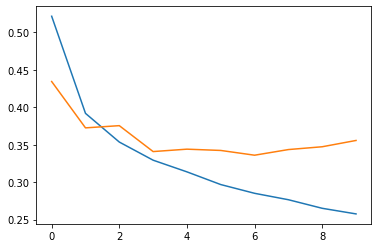

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

Tensorboard is a tool to analyze interactively the model. Callback functions are tools to do operations while training (e.g. TensorBoard or EarlyStopping). In EarlyStopping, you can establish a target value to monitor (e.g. accuracy or loss) and after how many epochs stop the iterations. It allows to not care about the epoch value and reduce the risk of overfitting

In [20]:
%load_ext tensorboard

In [ ]:
import datetime
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=f'logs/fit/{str(datetime.datetime.now())}')
model = build_model((28,28), 10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
history = model.fit(xtrain, ytrain, epochs=10, validation_split=0.1, callbacks=[tb_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1688/1688 [==============================] - 7s 3ms/step - loss: 0.5292 - accuracy: 0.8170 - val_loss: 0.4030 - val_accuracy: 0.8548
Epoch 2/10
1688/1688 [=====================

In [ ]:
%tensorboard --logdir logs/fit